In [1]:
%matplotlib inline
import os
import subprocess

import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import fiona
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import rasterio
import rasterio.mask
from matplotlib import colors
from osgeo import gdal
from rasterio.enums import Resampling
from skimage import exposure
from skimage.util import img_as_ubyte

plt.style.use("ggplot")

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Frisk Oslofjord machine learning: processing the multispectral dataset for the whole of Akerøya

## 1. Align and resample

In [2]:
# Snap raster
bounding_box = "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/boundingbox_10cm.tif"

# images
flist = [
    "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/raw/Merge_MS_Akeroy_V4_transparent_reflectance_blue.tif",
    "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/raw/Merge_MS_Akeroy_V4_transparent_reflectance_green.tif",
    "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/raw/Merge_MS_Akeroy_V4_transparent_reflectance_nir.tif",
    "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/raw/Merge_MS_Akeroy_V4_transparent_reflectance_red.tif",
    "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/raw/Merge_MS_Akeroy_V4_transparent_reflectance_rededge.tif",
]

# Loop over datasets
for fpath in flist:
    name = os.path.split(fpath)[1].split("_")[-1]
    out_path = (
        "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_"
        + name
    )
    print("Processing:", out_path)

    # Use rio warp. See https://rasterio.readthedocs.io/en/stable/cli.html#warp
    # Syntax: rio warp input.tif output.tif --like template.tif
    args = [
        "rio",
        "warp",
        fpath,
        out_path,
        "--like",
        bounding_box,
        "--overwrite",
        "--co",
        "compress=LZW",
        "--resampling",
        "bilinear",
    ]

    subprocess.check_call(args)

Processing: /home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_blue.tif
Processing: /home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_green.tif
Processing: /home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_nir.tif
Processing: /home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_red.tif
Processing: /home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_rededge.tif


## 2. Convert bit depth

In [3]:
def stretch_im(band, str_clip=2):
    """Modified from EarthPy - see here:

            https://github.com/earthlab/earthpy/blob/f391775874b94f7479c4b4c10630b68686f92f23/earthpy/plot.py#L315

    Stretch an image in numpy ndarray format using a specified clip value.

    Parameters
    ----------
    arr: numpy array
        1-dimensional array in rasterio order (rows, columns)
    str_clip: int
        The % of clip to apply to the stretch. Default = 2 (2 and 98)

    Returns
    ----------
    arr: numpy array with values stretched to the specified clip %
    """

    s_min = str_clip
    s_max = 100 - str_clip
    lower, upper = np.nanpercentile(band, (s_min, s_max))
    rescaled = exposure.rescale_intensity(band, in_range=(lower, upper))

    return rescaled.copy()

### 2.1. Explore range of data values

In [4]:
# List of 10 cm multispec images
flist = [
    "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_blue.tif",
    "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_green.tif",
    "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_nir.tif",
    "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_red.tif",
    "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_rededge.tif",
]

# Loop over images
for fpath in flist:
    ds_name = os.path.split(fpath)[1][:-4]
    ds = rasterio.open(fpath)
    data = ds.read(1)

    # Set no data
    data[data == -10000] = np.nan

    assert np.nanmin(data) >= 0
    dsmax = np.nanmax(data)
    if dsmax > 1:
        print(
            f"WARNING: Array for {ds_name} contains values greater than 1 (max = {dsmax:.2f}). Are you sure this is correct? These values will be set to 1."
        )
        data[data > 1] = 1

    # (Optional). Apply "linear stretch" histogram equalisation, as in EarthPy
    data = stretch_im(data)

    # Convert to 8-bit
    data = np.round(data * 255, decimals=0)

    print(np.nanmin(data), np.nanmax(data))

0.0 255.0
0.0 255.0
0.0 255.0
0.0 255.0
0.0 255.0


### 2.2. Convert to 8-bit and stack

In [5]:
# List of all 10 cm images. Order specifies band order in final mosaic
flist = [
    "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_red.tif",
    "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_green.tif",
    "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_blue.tif",
    "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_nir.tif",
    "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/multispec_rededge.tif",
]

# Output
out_tif = "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/akeroya_ms_all_8bit.tif"

# Read metadata of first file
with rasterio.open(flist[0]) as src:
    meta = src.meta

# Update meta to reflect the number of layers in output and NoData value
meta.update(count=len(flist), nodata=0, dtype="uint8")

# Read each layer and write it to stack
with rasterio.open(out_tif, "w", **meta, compress="LZW") as dst:
    for idx, fpath in enumerate(flist, start=1):
        # Get attributes from file name
        spec, name = os.path.split(fpath)[1].split("_")
        name = name[:-4]
        print("Processing:", spec, name)

        with rasterio.open(fpath) as src:
            # Read array
            data = src.read(1)

            if spec == "multispec":  # RGB data can be written directly
                # Set no data
                data[data == -10000] = np.nan

                assert np.nanmin(data) >= 0
                dsmax = np.nanmax(data)
                if dsmax > 1:
                    print(
                        f"    WARNING: Array contains values greater than 1 (max = {dsmax:.2f}). Are you sure this is correct? These values will be set to 1."
                    )
                    data[data > 1] = 1

                # (Optional). Apply linear stretch histogram equalisation, as in EarthPy
                data = stretch_im(data)

                # Convert to 8-bit
                data = np.round(data * 255, decimals=0)

                # Artificially adjust genuine zeros to ones
                data[data == 0] = 1

                # Set NoData as zero
                data[np.isnan(data)] = 0

                # Convert to uint8
                data = data.astype(np.uint8)

                print("    ", np.nanmin(data), np.nanmax(data))

            # Save to output
            dst.write_band(idx, data)

            # Add band description
            dst.set_band_description(idx, f"{spec}_{name}")

Processing: multispec red
     0 255
Processing: multispec green
     0 255
Processing: multispec blue
     0 255
Processing: multispec nir
     0 255
Processing: multispec rededge
     0 255


## 3. Check final dataset

In [6]:
# Output path
out_tif = "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/akeroya_ms_all_8bit.tif"

# Read downsampled version for better rendering speed
resamp_fac = 5

# Print dataset properties
with rasterio.open(out_tif) as src:
    band_titles = src.descriptions
    data = src.read(
        out_shape=(src.count, src.height // resamp_fac, src.width // resamp_fac),
        resampling=Resampling.average,
    )

    meta = src.meta
    for key in meta.keys():
        print(f"{key:10}:{meta[key]}")

driver    :GTiff
dtype     :uint8
nodata    :0.0
width     :18800
height    :22700
count     :5
crs       :EPSG:25832
transform :| 0.10, 0.00, 606970.00|
| 0.00,-0.10, 6547970.00|
| 0.00, 0.00, 1.00|


(<Figure size 864x864 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'multispec_red'}>,
         <AxesSubplot:title={'center':'multispec_green'}>,
         <AxesSubplot:title={'center':'multispec_blue'}>],
        [<AxesSubplot:title={'center':'multispec_nir'}>,
         <AxesSubplot:title={'center':'multispec_rededge'}>,
         <AxesSubplot:>]], dtype=object))

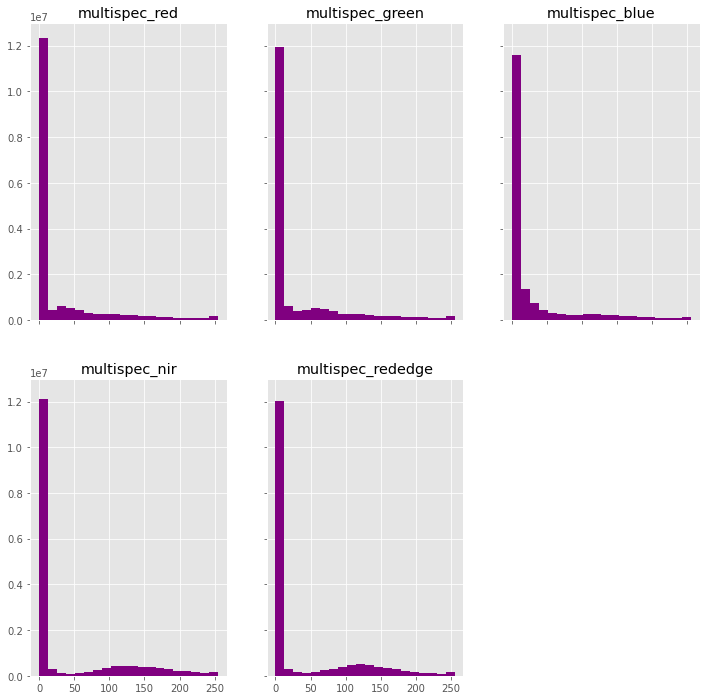

In [7]:
# Histograms of band values
ep.hist(data, cols=3, title=band_titles)

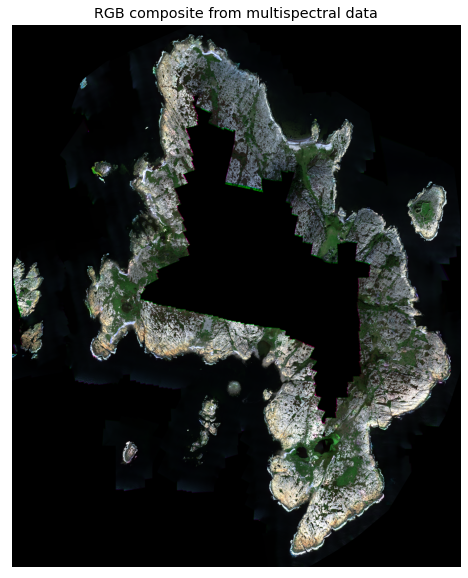

<Figure size 432x288 with 0 Axes>

In [8]:
# Plot RGB composite image
ep.plot_rgb(
    data,
    rgb=[0, 1, 2],
    # stretch=True,
    title="RGB composite from multispectral data",
)

plt.tight_layout()

## 4. Extract sub-images for training areas

In [9]:
# Loop over bounding boxes for areas
for area in range(1, 7):
    # Read bounding box
    shp_path = f"/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/vector/area_{area}.shp"
    with fiona.open(shp_path, "r") as shp:
        shapes = [feat["geometry"] for feat in shp]
    assert len(shapes) == 1

    # Read the full raster
    full_tif = "/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/akeroya_ms_all_8bit.tif"
    with rasterio.open(full_tif) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta

    # Write clipped raster to output
    tif_path = f"/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/training/ne_akeroya_10cm_area_{area}.tif"
    out_meta.update(
        {
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
        }
    )

    with rasterio.open(tif_path, "w", **out_meta, compress="LZW") as dest:
        dest.write(out_image)

## 5. Rasterise vector training data

In [10]:
# Loop over shapefiles
for area in range(1, 7):
    # Path rasters
    snap_tif = f"/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/training/ne_akeroya_10cm_area_{area}.tif"
    shp_path = f"/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/vector/area_{area}_classes.shp"
    tif_path = f"/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/training/ne_akeroya_10cm_area_{area}_man_class.tif"

    # Rasterise
    nivapy.spatial.shp_to_ras(
        shp_path,
        tif_path,
        snap_tif,
        "substrate",
        0,
        gdal.GDT_Int16,
    )

## 6. Visualise vector training data

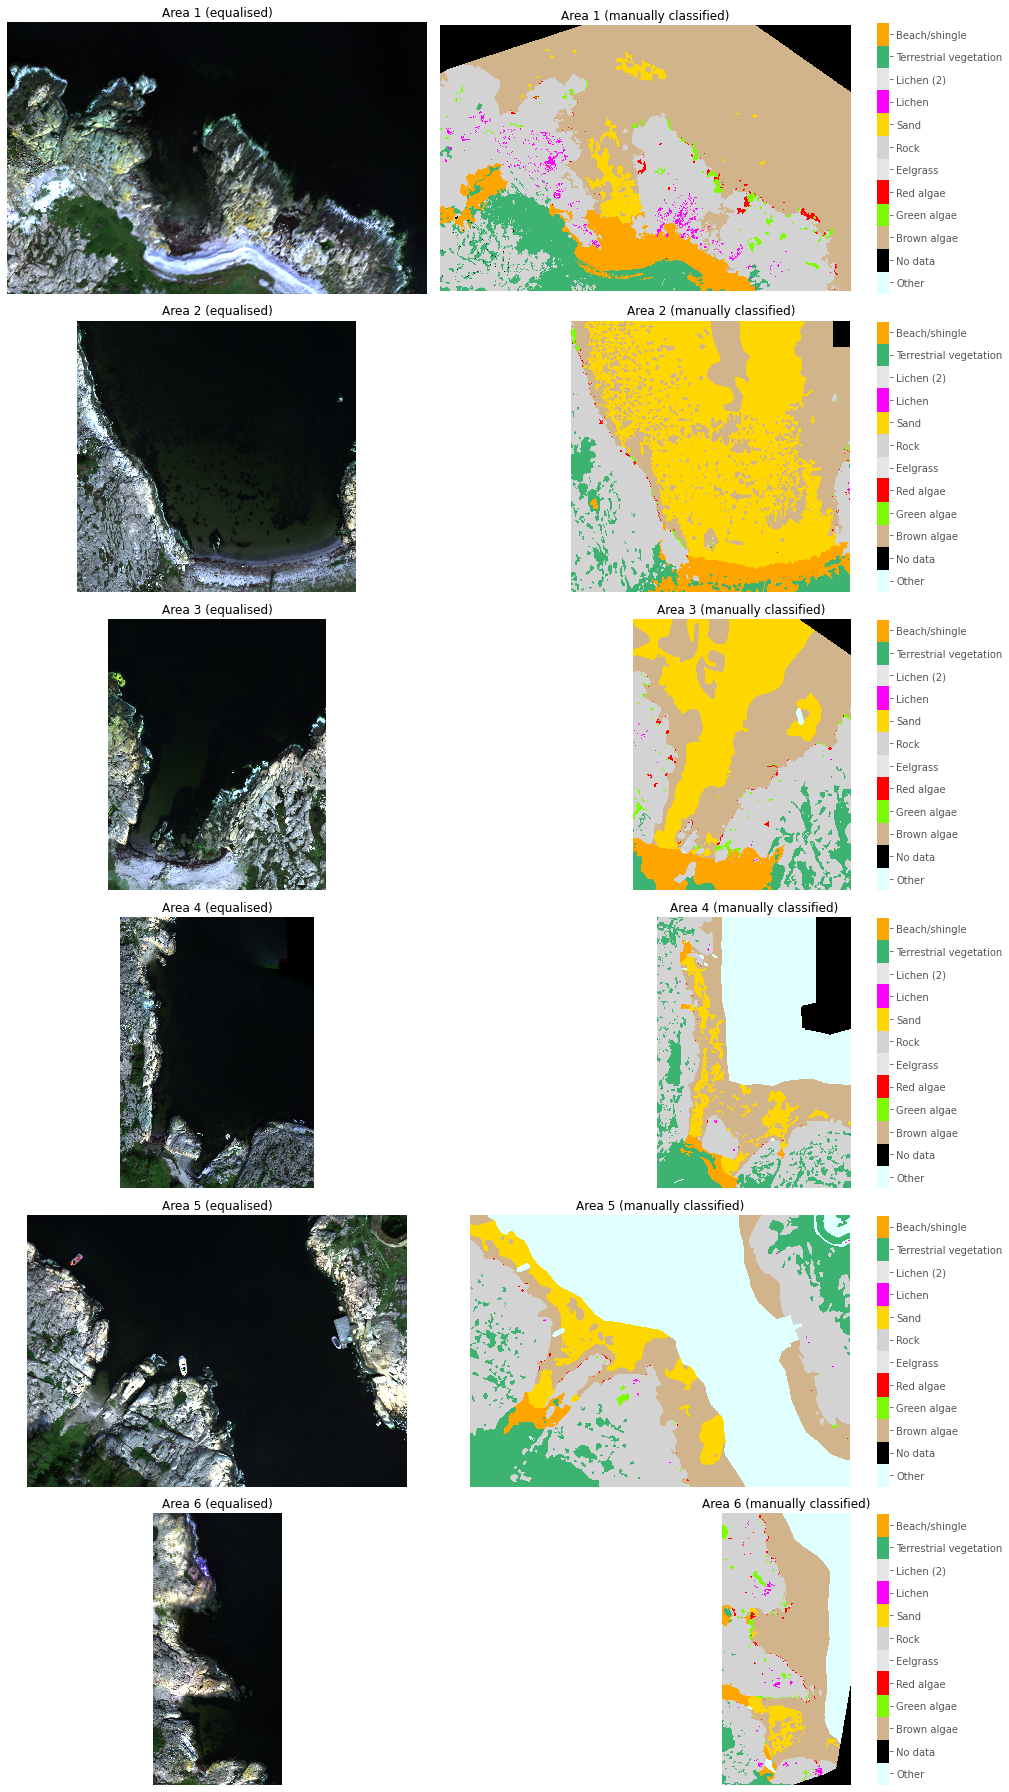

In [11]:
# Setup plot
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 25))

# Class codes
class_codes = {
    -1: "Other",
    0: "No data",
    1: "Brown algae",
    2: "Green algae",
    3: "Red algae",
    4: "Eelgrass",
    5: "Rock",
    6: "Sand",
    7: "Lichen",
    8: "Lichen (2)",
    9: "Terrestrial vegetation",
    10: "Beach/shingle",
}

# Define colours for classes. Ordered -1 to 10 (i.e. same as in 'class_codes', above)
cmap = colors.ListedColormap(
    [
        "lightcyan",
        "black",
        "tan",
        "lawngreen",
        "red",
        "none",
        "lightgrey",
        "gold",
        "magenta",
        "none",
        "mediumseagreen",
        "orange",
    ]
)
bounds = np.arange(-1.5, 11.5)
norm = colors.BoundaryNorm(bounds, cmap.N)

# Loop over data
for area in range(1, 7):
    idx = area - 1

    # Paths to images
    raw_path = f"/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/training/ne_akeroya_10cm_area_{area}.tif"
    man_path = f"/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/training/ne_akeroya_10cm_area_{area}_man_class.tif"

    # Read raw RGB bands to arrays
    band1, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=1)
    band2, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=2)
    band3, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=3)

    # Equalise images
    #     band1 = img_as_ubyte(exposure.equalize_hist(band1))
    #     band2 = img_as_ubyte(exposure.equalize_hist(band2))
    #     band3 = img_as_ubyte(exposure.equalize_hist(band3))

    raw_img = np.dstack((band1, band2, band3))

    # Read manually classified data (1 band only)
    man_img, ndv, man_epsg, extent = nivapy.spatial.read_raster(man_path, band_no=1)

    # Plot
    # Raw image
    axes[idx, 0].imshow(raw_img, interpolation="none")
    axes[idx, 0].set_title(f"Area {area} (RGB composite)", fontsize=12)

    # Manually classified
    img = axes[idx, 1].imshow(man_img, cmap=cmap, norm=norm, interpolation="none")
    axes[idx, 1].set_title(f"Area {area} (manually classified)", fontsize=12)

    # Turn off axes
    axes[idx, 0].axis("off")
    axes[idx, 1].axis("off")

    # Colourbar for manual dataset
    cb = plt.colorbar(img, ax=axes[idx, 1])
    labels = np.arange(-1, 11)
    cb.set_ticks(labels)
    cb.set_ticklabels(list(class_codes.values()))

plt.tight_layout()